In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy.integrate import quad
from scipy.special import sph_harm

Use function <span style="color:blue">phase_shifted_data</span> to get substellar shifted equatorial pressure field. Then feed that pressure field into <span style="color:blue">torque_info</span> which performs spherical harmonic decomposition and returns Im($\tilde{p_2}$) (torque), $|p_2|$ (amplitude), and lag angle. 

In [2]:
## substellar point moves with time, so at every timestep, calculate where substellar point is and shift pressure and temperature fields
## so that long = 0 is defined at the substellar point

def phase_shifted_data(data_path, num):
    
    data_name = nc.Dataset(data_path) # open data set
    ps = data_name['ps'] # get surface pressure [Pa]
    tsurf = data_name['tsurf'] # get surface temperature 

    ISW_surf = data_name['ISR'] # get incident stellar radiation to find substellar point
    time = data_name['Time']
    lon = data_name['longitude']
    lat = data_name['latitude']

    def shift_data(data, itime):
        lon_list = np.radians(lon) # convert to radians
        # find substellar point as maximum of ISW, look at equator since obliquity is zero
        where_substell = np.radians(lon[np.argmax(ISW_surf[itime, 24, :], axis = -1)]) 
        lon_list_shift = lon_list - where_substell # shift longitude to substellar reference frame
        for i in range(len(lon_list_shift)):
            if lon_list_shift[i] < 0:
                lon_list_shift[i] = 2*np.pi + lon_list_shift[i]
        sorted_index = np.argsort(lon_list_shift)
        lon_list_sorted = lon_list_shift[sorted_index]
        data_sorted = data[itime, 24, sorted_index] # sort data into new substellar reference frame
        return(data_sorted, lon_list_sorted) 
    # num = number of time steps to use in averaging
    stacked_temp = np.zeros([len(lon), num])
    stacked_pressure = np.zeros([len(lon), num])
    for i in range(len(time)-num, len(time)):
        temp, long = shift_data(tsurf[:, :, :], i) # shift surface temp data
        stacked_temp[:, -(len(time)-i)] = temp
        press, long = shift_data(ps[:, :, :], i) # shift surface pressure data
        stacked_pressure[:, -(len(time)-i)] = press

    avg_temp = np.mean(stacked_temp,axis = -1)
    avg_press = np.mean(stacked_pressure, axis = -1)
    return(avg_temp, avg_press) # return average surface temperature and pressure fields in substellar reference frame

In [3]:
def pressure(phi_int, p_data, lam):
    # phi_int = longitude evaluated by integral
    # allow interpolation of pressure field for integration
    return(np.interp(phi_int, lam, p_data)) 

def complex_mom_pressure(m, p_data, x_data):
    # perform spherical harmonic decomposition of surface pressure field (l = 2, m =+- 2)
    # p_data = pressure field from LMDZ
    # x_data = longitude list from LMDZ
    
    ## quad() ignores imaginary part, so decompose integral into real and imaginary part and then recombine
    p2_imag = quad(lambda phi: np.imag(np.conj(sph_harm(m,2,phi,np.pi/2))) * pressure(phi, p_data, x_data), 0, 2*np.pi)[0] # Equation (5), tilde(p_2)
    p2_real = quad(lambda phi: np.real(np.conj(sph_harm(m,2,phi,np.pi/2))) * pressure(phi, p_data, x_data), 0, 2*np.pi)[0]
    return(p2_real + 1j*p2_imag)

def torque_info(ps, x_data): # returns torque, amplitude, and lag
    # data = pressure field from LMDZ
    # x_data = longitude list from LMDZ
    p22 = complex_mom_pressure(2, np.array(ps), x_data) # m = 2
    p2m2 = complex_mom_pressure(-2, np.array(ps), x_data) # m = -2
    arg = np.arctan(np.imag(p22)/np.real(p22))
    lag = np.sin(2*0 - arg)
    amp = np.absolute(p22)
    im_qa = np.imag(p22)
    return([amp, im_qa, lag])

### Example

In [7]:
direc = '/n/wordsworth_lab/asalazar/sens_tests/tausw_grey/' # directory where data is

run_name_0 = '1bar_2n_1360_grey_tausw_1/' # case-name (CO2 = 0 ppm, real gas simulation)

data_path_0 = direc + run_name_0 + 'diagfi1.nc' # output file containing data

avg_temp_0, avg_press_0 = phase_shifted_data(data_path_0, 50) # get temperature and pressure data at equator, averaged over 250 timesteps (500 days)


In [8]:
## show temp and pressure plots as an example

Text(0, 0.5, '$p_s$ (bar)')

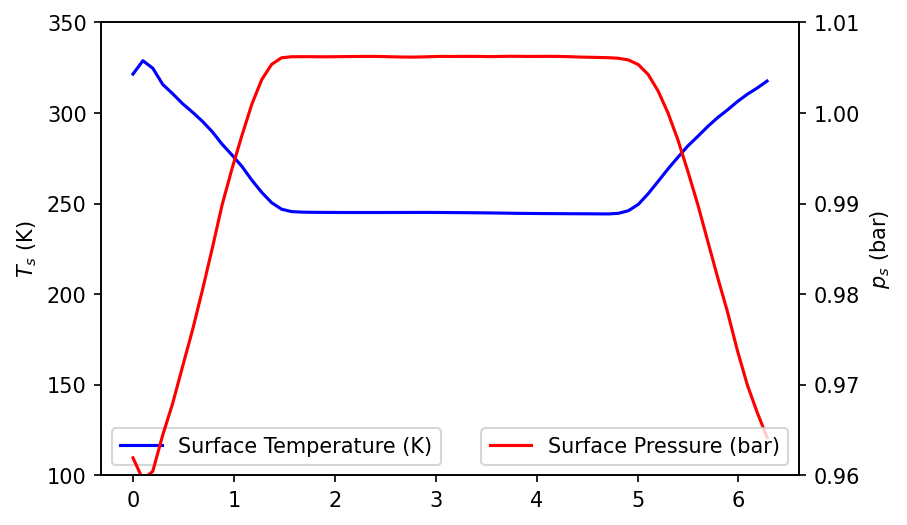

In [9]:
lon_list = np.linspace(0, 2*np.pi, len(avg_temp_0))
fig, ax = plt.subplots(1,dpi=150)
ax.plot(lon_list, avg_temp_0, 'b', label = 'Surface Temperature (K)')
ax.set_ylabel('$T_s$ (K)')
ax.legend(loc = 'lower left')
ax.set_ylim(100,350)
ax2 = ax.twinx()
ax2.plot(lon_list, avg_press_0/1e5, 'r', label = 'Surface Pressure (bar)')
ax2.legend(loc = 'lower right')
ax2.set_ylim(0.96,1.01)
ax2.set_ylabel('$p_s$ (bar)')

In [10]:
print('Im_q = ' + str(torque_info(avg_press_0, lon_list)[1]))
print('amp = ' + str(torque_info(avg_press_0, lon_list)[0]))
print('lag = ' + str(torque_info(avg_press_0, lon_list)[2]))

Im_q = 275.2858058677739
amp = 1326.127868853183
lag = 0.20758617048432687


<ipython-input-3-2cd3098b176c>:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p2_imag = quad(lambda phi: np.imag(np.conj(sph_harm(m,2,phi,np.pi/2))) * pressure(phi, p_data, x_data), 0, 2*np.pi)[0] # Equation (5), tilde(p_2)
<ipython-input-3-2cd3098b176c>:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain f